# Introdução aos Algoritmos Bioinspirados
## Estudo de caso: Análise do estado de conservação de painéis fotovoltaicos

<sub><sub>*por Thyago de Oliveira Freitas*</sub></sub>
---

Este material usou como base o seguinte notebook no kaggle: https://www.kaggle.com/code/sarthakbhatore/solar-panel-dust-detection 

## Criação de um modelo de rede neural

<a name="referencias"></a>
As redes neurais se destacam como uma das técnicas de aprendizagem de máquina mais proeminentes da atualidade [[1]](#ref1). Graças aos avanços significativos nas metodologias e na capacidade de processamento computacional, os modelos baseados em redes neurais conseguem realizar predições aproximadas ao identificar padrões complexos em grandes volumes de dados. Suas aplicações são amplas e diversificadas, abrangendo áreas como engenharia, saúde, linguística, entre muitas outras.

Atualmente, um modelo de rede neural, mesmo que simples, pode ser utilizado como ponto de partida para a análise exploratória de conjuntos de dados [[2]](#ref2). Isso permite uma compreensão inicial das estruturas subjacentes nos dados, facilitando o desenvolvimento de soluções mais avançadas. Portanto, possuir um conhecimento básico sobre redes neurais é fundamental para conduzir pesquisas eficazes e inovadoras nesse contexto.

<a id="ref1"></a>
[1] Mirjalili, S., Faris, H., & Aljarah, I., 2020. ***Evolutionary Machine Learning Techniques***. https://doi.org/10.1007/978-981-32-9990-0.

<a id="ref2"></a>
[2] Gazder, U., Ahmed, A., & Shahid, U., 2018. ***Application Of Artificial Neural Networks For Exploratory Analysis Of Small Dataset***. 2018 International Conference on Innovation and Intelligence for Informatics, Computing, and Technologies (3ICT), pp. 1-6. https://doi.org/10.1109/3ICT.2018.8855768.

### Import das bibliotecas

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import PIL
import shutil
import numpy as np
from rich.table import Table
from rich.console import Console
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_io")

### Divisão das imagens em conjuntos de treino, teste e validação

In [3]:
# Criando diretórios para treino, teste e validação, caso não existam

for dir_name in ['working/train', 'working/test', 'working/validate']:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        
classes = ['Clean', 'Dusty']

In [4]:
def train_test_div(class_name, base_dir = 'Detect_solar_dust/'):
    for subdir in ['/train/', '/test/', '/validate/']:
        os.makedirs(f'working{subdir}{class_name}', exist_ok=True)
        
    list_files = os.listdir(os.path.join(base_dir, class_name))
    files = [os.path.join(base_dir, class_name, f) for f in list_files]
    
    train_files, test_validate_files = train_test_split(files, test_size=0.3, random_state=42)
    test_files, validate_files = train_test_split(test_validate_files, test_size=(1/3), random_state=42)
    
    for f in train_files:
        shutil.copy(f, f'working/train/{class_name}/')
    for f in test_files:
        shutil.copy(f, f'working/test/{class_name}/')
    for f in validate_files:
        shutil.copy(f, f'working/validate/{class_name}/')
        
    return len(train_files), len(test_files), len(validate_files)

In [5]:
console = Console()

table = Table(title="Resumo da divisão das imagens em treino e teste")

table.add_column("Class Name", justify="left", style="cyan", no_wrap=True)
table.add_column("Train Size", justify="right", style="green")
table.add_column("Test Size", justify="right", style="green")
table.add_column("Validation Size", justify="right", style="green")

# Para cada classe, calcula os tamanhos dos conjuntos e adiciona à tabela
for class_name in classes:
    tr, te, val = train_test_div(class_name)
    table.add_row(class_name, str(tr), str(te), str(val))

# Exibe a tabela no console
console.print(table)

     Resumo da divisão das imagens em treino e teste     
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Class Name ┃ Train Size ┃ Test Size ┃ Validation Size ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Clean      │       1045 │       298 │             150 │
│ Dusty      │        748 │       214 │             107 │
└────────────┴────────────┴───────────┴─────────────────┘

## Aplicando transformações nas imagens:
---------------

Antes de passar as imagens para o modelo de rede neural, é importante aplicar uma transformação nos dados, de forma a normalizar as informações na entrada, e aumentar a robustez da predição através de pequenas modificações nas imagens, como ajustes no brilho e na orientação, para que a rede seja capaz de identificar o objeto mesmo com pequenos "desvios".

### Explicação sobre os hiperparâmetros

| **Hiperparâmetro**      | **Descrição (aplicada ao código abaixo)**                                                                                                                              |
|-------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **BATCH_SIZE**           | Define o número de imagens processadas pelo modelo de cada vez.                                                                                                |
| **image_height**         | Padroniza a altura de todas as imagens.                                                                                                                        |
| **image_width**          | Padroniza a largura de todas as imagens.                                                                                                                       |
| **ImageDataGenerator**   | Aplica transformações nas imagens antes de entrar no modelo.                                                                                                   |
| **rescale**              | Normaliza os valores dos pixels (passa da escala RGB, de 0 a 255, para o intervalo entre 0 e 1) — ajuda a estabilizar o processo de aprendizagem!              |
| **rotation_range**       | Define um grau de rotação nas imagens — 5 graus (importante para que o modelo reconheça o objeto independentemente de como a foto foi gerada).                 |
| **width_shift_range**    | Define um grau de deslocamento horizontal nas imagens — 5%.                                                                                                    |
| **height_shift_range**   | Define um grau de deslocamento vertical nas imagens — 5%.                                                                                                      |
| **shear_range**          | Define um intervalo de cisalhamento (shearing) — distorce levemente a imagem, o que permite simular diferentes perspectivas.                                   |
| **zoom_range**           | Amplia ou reduz aleatoriamente a imagem em 5%.                                                                                                                 |
| **brightness_range**     | Intervalo para ajuste do brilho. Simula diferentes condições de iluminação do ambiente.                                                                        |
| **horizontal_flip**      | Controla se as imagens são invertidas horizontalmente. Para essa aplicação, esse parâmetro está desligado (false).                                             |
| **vertical_flip**        | Controla se as imagens são invertidas verticalmente. Para essa aplicação, esse parâmetro está desligado (false).                                               |
| **fill_mode**            | Determina como os pixels serão preenchidos depois da transformação. "nearest" significa que os novos pixels serão preenchidos com valores próximos da borda.   |



In [7]:
BATCH_SIZE = 48
image_height = 224
image_width = 224

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'                                   
)

In [8]:
# Train generator
test_val_data_generator = ImageDataGenerator(rescale=1./255)

# Gerador utilizado no processo de treino
train_generator = train_data_generator.flow_from_directory(
    directory="working/train",                                          # Busca as imagens na pasta de treino
    color_mode="rgb",                                                   # Carrega as imagens no modo de cor RGB
    target_size=(image_height, image_width),                            # Redimensiona as imagens para o tamanho especificado
    class_mode="categorical",                                           # Codifica das imagens de acordo com o padrão one-hot encoding (1 para classe correta, 0 para as demais)
    batch_size=BATCH_SIZE,                                              # Define a quantidade de imagens que serão processadas a cada vez
    shuffle=True,                                                       # Embaralha as imagens
    seed=1234                                                           # Define uma semente para o gerador aleatório (importante para a reprodutibilidade do experimento!)
)

# Gerador utilizado no processo de teste
test_generator = test_val_data_generator.flow_from_directory(
    directory="working/test",                                           # Busca as imagens na pasta de teste
    color_mode="rgb",                                                   # Carrega as imagens no modo de cor RGB
    target_size=(image_height, image_width),                            # Redimensiona as imagens para o tamanho especificado
    class_mode="categorical",                                           # Codifica das imagens de acordo com o padrão one-hot encoding (1 para classe correta, 0 para as demais)
    batch_size=BATCH_SIZE,                                              # Define a quantidade de imagens que serão processadas a cada vez
    shuffle=False,                                                      # NÃO embaralha as imagens
    seed=1234                                                           # Define uma semente para o gerador aleatório (importante para a reprodutibilidade do experimento!)
)

# Gerador utilizado no processo de validação
validate_generator = test_val_data_generator.flow_from_directory(
    directory="working/validate",                                       # Busca as imagens na pasta de validação
    color_mode="rgb",                                                   # Carrega as imagens no modo de cor RGB
    target_size=(image_height, image_width),                            # Redimensiona as imagens para o tamanho especificado
    class_mode="categorical",                                           # Codifica das imagens de acordo com o padrão one-hot encoding (1 para classe correta, 0 para as demais)
    batch_size=BATCH_SIZE,                                              # Define a quantidade de imagens que serão processadas a cada vez
    shuffle=False,                                                      # NÃO embaralha as imagens
    seed=1234                                                           # Define uma semente para o gerador aleatório (importante para a reprodutibilidade do experimento!)
)

Found 2318 images belonging to 2 classes.
Found 918 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [8]:
# Obtendo o mapeamento dos nomes das classes para os índices correspondentes
dict_class = train_generator.class_indices
print('Dicionário: {}'.format(dict_class))

# Extraindo os nomes das classes
class_names = list(dict_class.keys())
print('Nomes das classes: {}'.format(class_names))

Dicionário: {'Clean': 0, 'Dusty': 1}
Nomes das classes: ['Clean', 'Dusty']


In [9]:
from rich.columns import Columns

console = Console()

# Função para gerar as tabelas
def create_dataset_table(title, generator):
    table = Table(title=title, show_header=True, header_style="bold magenta")
    table.add_column("Classe", justify="center")
    table.add_column("Número de imagens", justify="center")
    
    total_images = len(generator.classes)
    for class_name, class_index in generator.class_indices.items():
        num_images = sum(generator.classes == class_index)
        table.add_row(class_name, str(num_images))
    
    table.add_row("[bold]Total[/bold]", f"[bold]{total_images}[/bold]", style="bold green")
    return table

# Cria as tabelas para cada dataset
train_table = create_dataset_table("Conjunto de treinamento", train_generator)
test_table = create_dataset_table("Conjunto de teste", test_generator)
validate_table = create_dataset_table("Conjunto de validação", validate_generator)

# Exibe as tabelas lado a lado
console.print(Columns([train_table, test_table, validate_table]))

   Conjunto de treinamento           Conjunto de teste            Conjunto de validação     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓ ┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓ ┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Classe ┃ Número de imagens ┃ ┃ Classe ┃ Número de imagens ┃ ┃ Classe ┃ Número de imagens ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩ ┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩ ┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Clean  │       1346        │ │ Clean  │        534        │ │ Clean  │        282        │
│ Dusty  │        972        │ │ Dusty  │        384        │ │ Dusty  │        202        │
│ Total  │       2318        │ │ Total  │        918        │ │ Total  │        484        │
└────────┴───────────────────┘ └────────┴───────────────────┘ └────────┴───────────────────┘

### Data Augmentation

Se você prestou atenção, perceberá que há mais imagens nos conjuntos de treino, teste e validação agora do que quando foi dividido no início. Isso ocorre porque a classe ImageDataGenerator aplicou um procedimento denominado *Data Augmentation*, que é quando conseguimos aumentar a quantidade de dados sem realizar novas coletas. Isso envolve a transformação dos dados iniciais através da aplicação de rotação, mudanças no brilho, contraste, orientação, etc. O objetivo desse procedimento é aumentar a robustez do processo de treinamento do modelo para que ele consiga lidar melhor com as variações que podem ocorrer no mundo real.

Exibindo as imagens do conjunto de treinamento após a etapa de Data Augmentation


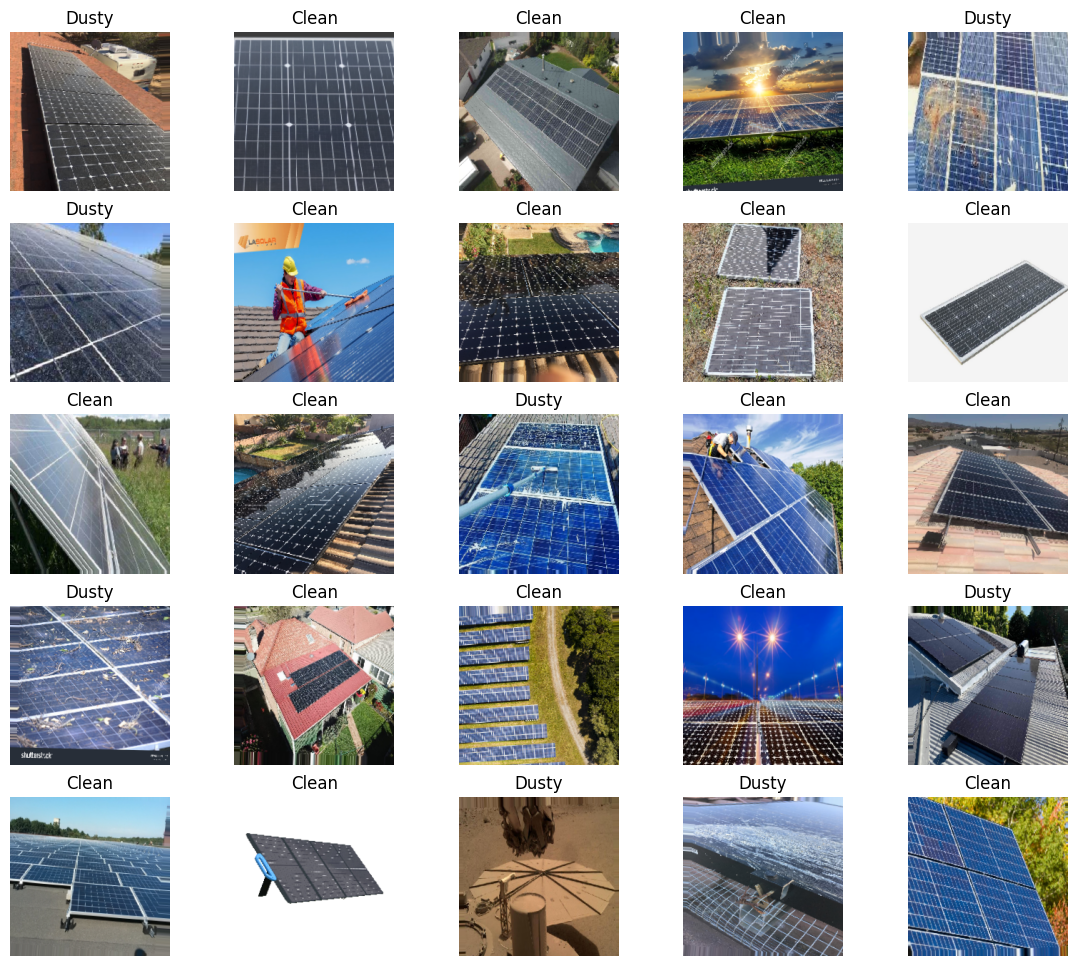

In [10]:
print('Exibindo as imagens do conjunto de treinamento após a etapa de Data Augmentation')
img, label = next(train_generator)

plt.figure(figsize=[14, 12])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

## Transferência de Aprendizado

A transferência de aprendizado é uma técnica em redes neurais que permite utilizar um modelo previamente treinado em um conjunto de dados para resolver uma nova tarefa. Neste projeto, adotaremos o VGG16 como base para desenvolver um modelo de detecção do estado dos painéis fotovoltaicos. O VGG16 é uma rede neural convolucional (CNN) altamente eficaz, reconhecida por sua excelência em tarefas de classificação. Desenvolvido por Karen Simonyan e Andrew Zisserman da Universidade de Oxford, o VGG16 foi destacado no ImageNet Large-Scale Visual Recognition Challenge, onde conquistou o 1º e 2º lugares na detecção e classificação de objetos, alcançando uma precisão de 92,7% na classificação de imagens pertencentes a 1000 categorias distintas.

**Fontes**:

Artigo da conferência: https://arxiv.org/pdf/1409.1556

Documentação no keras: https://keras.io/api/applications/vgg/

**Arquitetura do VGG16**:

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*0M8CobXpNwFDCmOQ">


<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*6VP81rFoLWp10FcG">

**Fonte das Imagens**: https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

### Importando o modelo VGG16

In [17]:
base_model = VGG16(weights='imagenet',                              # Carrega os pesos do VGG16 que foi treinado no conjunto de dados imagenet
                   include_top=False,                               # Exclui as camadas finais (Dense) do VGG16, deixando apenas as de Pooling e de Convolução. Isso permite criar camadas especializadas para a aplicação.
                   input_shape=(image_height, image_width, 3))      # Define o formato de entrada (nesse caso, optei por manter o padrão 224x224x3, mas outras configurações podem ser utilizadas).

In [18]:
base_model.trainable = False                                        # Congela as camadas remanescentes do VGG16 (isso significa que os pesos para essas camadas não serão atualizados).

### Criando camadas customizadas e adicionando o VGG16

In [29]:
model = models.Sequential()                                         # Cria o modelo no formato "Sequential" (permite empilhar as camadas linearmente).
model.add(base_model)                                               # Coloca o VGG no início do modelo
model.add(layers.Flatten())                                         # Achata a saída 2D da camada convolucional para um vetor 1D (necessário para as camadas densas).
model.add(layers.Dense(256, activation='relu'))                     # Cria uma camada densa com 256 neurônios e função de ativação ReLU (importante para aprender as características não-lineares).
model.add(layers.Dropout(0.5))                                      # Dropout de 50% (desliga 50% dos dados da camada anterior, importante para evitar superajustamento do modelo).
model.add(layers.Dense(len(class_names), activation='softmax'))     # Adiciona uma camada densa final com o tamanho igual das classes (2 -- "clean" e "dirty").

In [13]:
model.compile(optimizer='adam',                                     # Otimizador Adam: utilizado na otimização do processo de treinamento da rede neural.
              loss='categorical_crossentropy',                      # Função de perda categorical_crossentropy: adequada para situações onde é necessário a classificação de múltiplas classes.
              metrics=['accuracy'])                                 # Métrica: medida pelo qual o modelo sabe se está melhorando ou piorando o seu treinamento.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Lidando com o desbalanceamento das classes

Neste cenário, onde há um número significativamente maior de imagens em uma classe em comparação com outras, é possível que ocorra um desbalanceamento de classes. Isso pode levar o modelo a ter um desempenho superior na previsão das classes majoritárias, enquanto as classes minoritárias podem ser sub-representadas e negligenciadas. Para enfrentar esse problema, uma abordagem comum é atribuir pesos diferentes às classes. Ao aumentar o peso das classes minoritárias, garantimos que elas recebam mais atenção durante o treinamento, ajudando o modelo a aprender de maneira mais equilibrada e a melhorar a precisão na previsão dessas classes menos representadas.

In [34]:
class_weights = compute_class_weight(class_weight = "balanced",                     # Ajusta os pesos de acordo com a frequência de cada classe
                                     classes= np.unique(train_generator.classes),   # Verifica a quantidade de classes com base no train_generator
                                     y= train_generator.classes)                    # Obtêm as classes
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))        # Transforma o array de pesos em um dicionário, onde a chave são os índices e os valores são os pesos correspondentes.
class_weights

{0: 0.8610698365527489, 1: 1.1923868312757202}

### Treinando o modelo

Crie uma célula python para executar o código abaixo (~1h de execução)

```python
epoch = 15                                                # Define o número de épocas para o treinamento
history = model.fit(train_generator,                      # Gerador de dados para o treinamento 
                    validation_data=validate_generator,   # Gerador de dados para a validação
                    epochs=epoch,                
                    class_weight=class_weights)           # Pesos definidos na etapa anterior
```

### Salvando o modelo

In [35]:
from pickle import dump
from tensorflow.keras.models import save_model

with open('artifacts/history.pkl','wb') as h:
    dump(history, h)
    
model.save('artifacts/model.keras')

### Carregando o modelo treinado

In [9]:
from pickle import load
from tensorflow.keras.models import load_model

with open('artifacts/history.pkl', 'rb') as h:
    history = load(h)
    
model = load_model('artifacts/model.keras')

/home/thyago/Documentos/Python/curso-bio/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Visualizando a acurácia do modelo no treino e validação

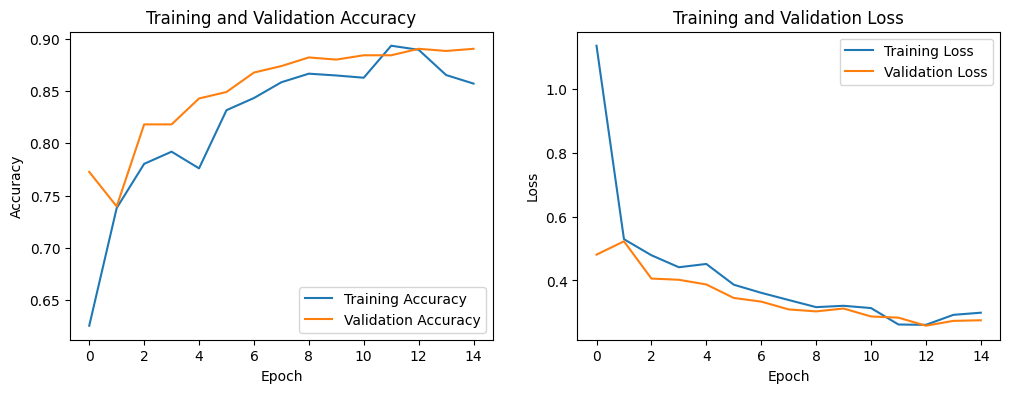

In [10]:
# Extract training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
evaluation = model.evaluate(test_generator)

loss, accuracy = evaluation

print("Resultados:")
print("Perda no teste: {:.4f}".format(loss))
print("Acurácia no teste: {:.2%}".format(accuracy))

/home/thyago/Documentos/Python/curso-bio/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-09 21:21:56.151716: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2024-09-09 21:21:56.430615: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2024-09-09 21:21:57.116442: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-09-09 21:21:57.253455: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.


15/20 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.9180 - loss: 0.2148

/home/thyago/Documentos/Python/curso-bio/.venv/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9164 - loss: 0.2229
Resultados:
Perda no teste: 0.2409
Acurácia no teste: 91.50%


### Comparando as predições realizadas pelo modelo e comparando com os rótulos reais

In [24]:
# Armazena os rótulos verdadeiros e os preditos pelo modelo
true_labels = []
predictions = []

# Reseta o gerador (para garantir que ele forneça as imagens desde o início)
# Lembrete: esse gerador é o mesmo utilizado na etapa de validação. Por isso ele precisa ser reiniciado.
test_generator.reset()

# Loop through the test generator to accumulate true labels and predictions
for i in range(len(test_generator)):
    images, labels = next(test_generator)     # Para cada iteração, ele retorna o próximo lote de imagens
    true_labels.extend(labels)                # Adiciona os rótulos para a lista de true_labels
    predictions_batch = model.predict(images) # Prevê os rótulos através do modelo
    predictions.extend(predictions_batch)     # Armazena os rótulos preditos na lista predictions

# Convert lists to NumPy arrays
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


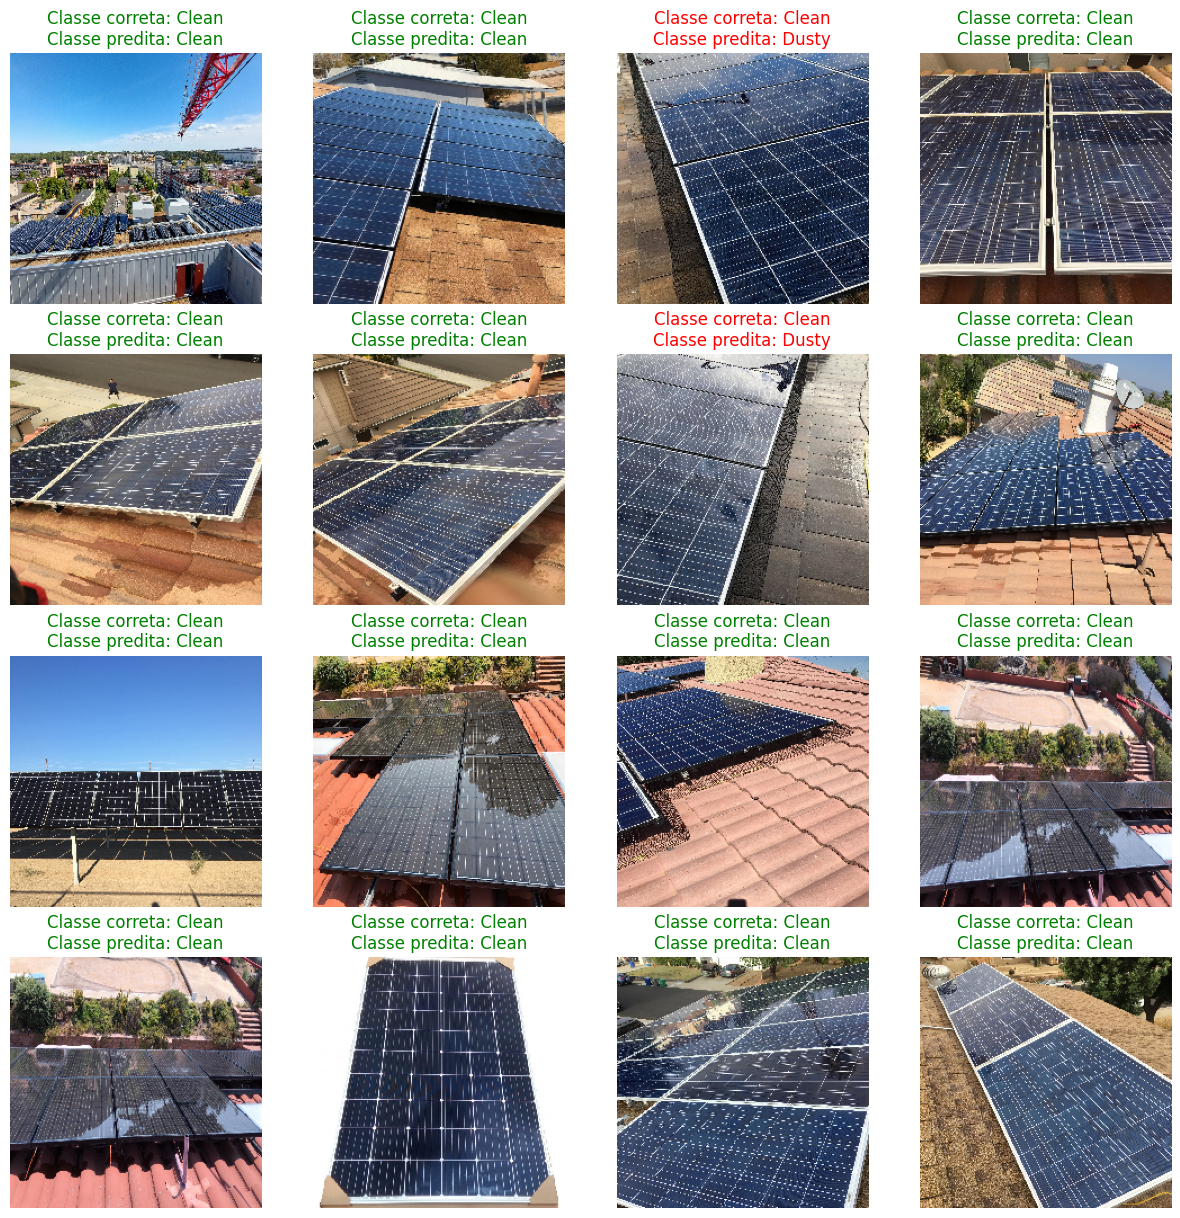

In [26]:
num_samples = 16  # Vai exibir 16 imagens em um grid 4x4

# Reseta o gerador para o início
test_generator.reset()

# Obtêm um lote de imagens e labels usando o test_generator
images, true_labels = next(test_generator)

# Usa o modelo treinado para fazer predições no batch de imagens
predictions_batch = model.predict(images)

# Converte as predições e os labels em arrays numpy
# Aqui, o argmax é usado para converter os rótulos do formato one-hot encoding em índices de classes
predictions = np.argmax(predictions_batch, axis=1)
true_labels = np.argmax(true_labels, axis=1)

# Retorna as imagens para a escala [0, 255] -- RGB
images = (images * 255).astype("uint8")

# Exibe um conjunto de imagens as classes corretas e as preditas
plt.figure(figsize=(15, 15))
for i in range(min(num_samples, len(true_labels))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]) 
     
    if class_names[true_labels[i]] == class_names[predictions[i]]:
        title_color = 'green'
    else:
        title_color = 'red'
    
    plt.title("Classe correta: {}\nClasse predita: {}".format(class_names[true_labels[i]], class_names[predictions[i]]), color=title_color)
    plt.axis("off")

plt.show()

## Tranformando o modelo de classificação em um de regressão

In [11]:
# Modelo pré-treinado VGG16
base_model = VGG16(weights='imagenet',                                
                   include_top=False,                                  
                   input_shape=(image_height, image_width, 3))   

base_model.trainable = False  

# Construção do modelo
model = models.Sequential()                                             
model.add(base_model)                                                   
model.add(layers.Flatten())                                             
model.add(layers.Dense(256, activation='relu'))                         
model.add(layers.Dropout(0.5))

# ----- Preste atenção nessa parte: -------
# Nos modelos de regressão, o objetivo é retornar um valor contínuo, que funciona como um score.
# Nesse caso, apenas um neurônio é utilizado na camada de saída, pois ele retorna esse valor.
# Para a função de ativação, escolhi a linear, onde ele simplesmente joga na saída o valor ponderado pela rede.                                         
model.add(layers.Dense(1, activation='linear')) 

# Compilar o modelo
# Importante! Geralmente em modelos de regressão, tentamos reduzir a diferença entre o valor predito e o real utilizando algum cálculo de erro.
model.compile(optimizer='adam',                                         
              loss='mean_squared_error',        
              metrics=['mean_absolute_error'])
model.summary()

# Como é regressão, não precisamos de class weights

# Treinamento do modelo
epoch = 15
history = model.fit(train_generator,                      
                    validation_data=validate_generator,   
                    epochs=epoch)

I0000 00:00:1725881584.301496    7606 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15


/home/thyago/Documentos/Python/curso-bio/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/thyago/Documentos/Python/curso-bio/.venv/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - loss: 17.9957 - mean_absolute_error: 2.7960 - val_loss: 0.2916 - val_mean_absolute_error: 0.5000
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - loss: 0.3085 - mean_absolute_error: 0.5007 - val_loss: 0.2581 - val_mean_absolute_error: 0.5000
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - loss: 0.2946 - mean_absolute_error: 0.5012 - val_loss: 0.2597 - val_mean_absolute_error: 0.5000
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - loss: 0.2872 - mean_absolute_error: 0.5000 - val_loss: 0.2636 - val_mean_absolute_error: 0.5000
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - loss: 0.2861 - mean_absolute_error: 0.5001 - val_loss: 0.2593 - val_mean_absolute_error: 0.5000
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - loss: 0.2843 - mean_absolute_error: 0.5002 - val_loss: 0.2600 - val_mean_absolute_error: 0.5000
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - loss: 0.2819 - mean_absolute_error: 0.5000 - val_loss: 0.2558 -

In [20]:
from pickle import dump
from tensorflow.keras.models import save_model

with open('artifacts/history_regression.pkl','wb') as h:
    dump(history, h)
    
model.save('artifacts/model_regression.keras')

In [ ]:
from pickle import load
from tensorflow.keras.models import load_model

with open('artifacts/history_regression.pkl', 'rb') as h:
    history = load(h)
    
model = load_model('artifacts/model_regression.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


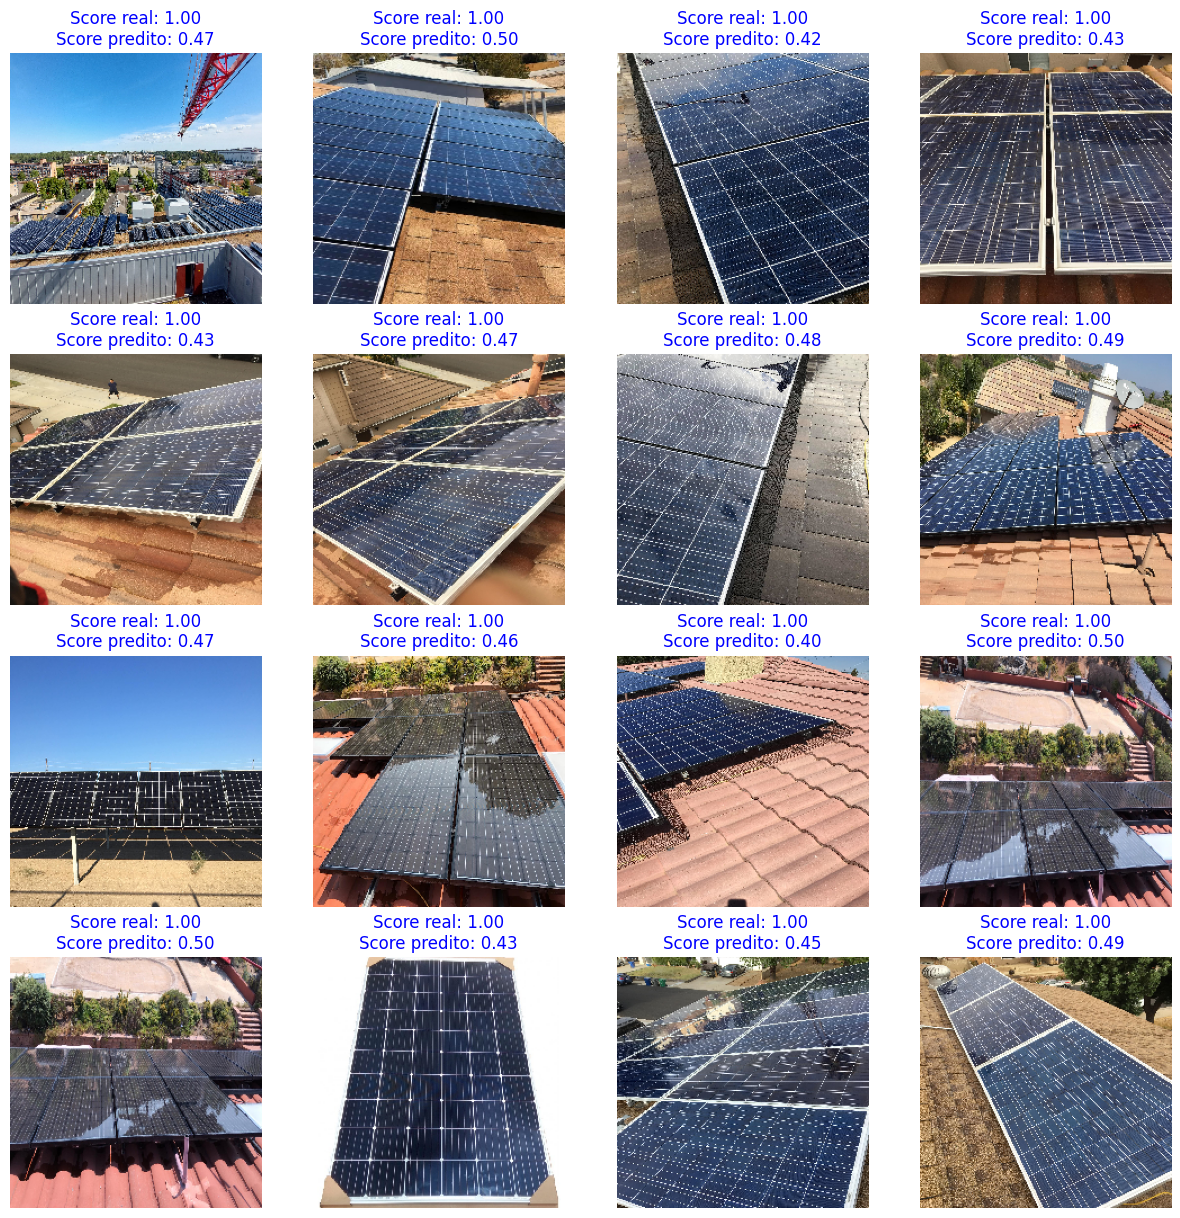

In [19]:
num_samples = 16 

# Resetar o gerador de teste para o início
test_generator.reset()

# Obter um lote de imagens e labels reais do gerador de teste
images, true_labels = next(test_generator)

# Previsões para o lote
predictions_batch = model.predict(images)

# Reescalar os valores de pixel para o intervalo [0, 255]
images = (images * 255).astype("uint8")

# Visualizar uma amostra de imagens com os scores reais e preditos
plt.figure(figsize=(15, 15))
for i in range(min(num_samples, len(true_labels))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])

    # Comparar o valor real com o predito, pegando o valor escalar do array
    true_value = true_labels[i][0]  # Obtendo o valor escalar
    predicted_value = predictions_batch[i][0]  # Obtendo o valor escalar

    plt.title(f"Score real: {true_value:.2f}\nScore predito: {predicted_value:.2f}", color='blue')
    plt.axis("off")

plt.show()

## *Particle Swarm Optimization* (PSO)
### Otimização dos hiperparâmetros da Rede Neural
---

PSO é um algoritmo de otimização baseado no comportamento social de aves e peixes. Ele é bastante utilizado para encontrar soluções globais para problemas complexos, principalmente quando a função objetivo é difícil de encontrar. 

### Conceitos básicos

O PSO utiliza como base o conceito de "partículas", que fazem uma analogia aos pássaros ou peixes, e que na prática representam possíveis soluções para o problema. Cada partícula tem uma possui uma posição e uma velocidade, e elas "voam" por todo o espaço de soluções.

A movimentação das partículas é baseada por dois fatores:

- **Experiência pessoal**: cada partícula lembra a melhor posição alcançada.
- **Experiência coletiva**: cada partícula é influenciada pela melhor posição encontrada pelo grupo.

### Parâmetros do PSO

- **w (Coeficiente de inércia)**: influencia a velocidade das partículas. Um valor muito próximo de 1 favorece a exploração global, permitindo alcançar regiões distantes dentro do espaço de busca. Por outro lado, valores próximos de 0 favorecem a exploração local, fazendo com que as partículas se concentrem em regiões próximas às suas melhores posições encontradas. Um ajuste adequado do w é importante para evitar que as partículas fiquem presas em um mínimo local.

- **c1 (Fator cognitivo)**: controla a influência da melhor posição encontrada por uma partícula (pbest) na atualização da sua velocidade. Por exemplo, um alto c1 faz com que a partícula confie mais em sua própria experiência e se mova na direção da melhor solução encontrada por ela, enquanto que um baixo c1 reduz a importância da experiência individual da partícula.

- **c2 (Fator social)**: controla a influência da melhor posição encontrada por todo o enxame (gbest) na atualização da velocidade das partículas. Um alto c2 faz com que a partícula confie mais na experiência do enxame e tenda a se mover em direção à melhor posição global encontrada, enquanto um baixo c2 reduz a importância da experiência do grupo.

### Função fitness com todos os parâmetros

```python
def fitness_function(params):
    # params é um array 2D, então precisamos iterar sobre cada partícula

    # Inicializa uma lista para armazenar os custos (valores de fitness)
    costs = []

    for particle in params:
        learning_rate = particle[0]
        neurons = int(particle[1])  # Convertendo para int
        dropout_rate = particle[2]
        epochs = int(particle[3])  # Convertendo para int
        batch_size = int(particle[4])  # Convertendo para int

        # Atualizar modelo com os hiperparâmetros fornecidos
        model = models.Sequential()
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
        base_model.trainable = False

        model.add(base_model)
        model.add(layers.Flatten())
        model.add(layers.Dense(neurons, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(len(class_names), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

        # Treina o modelo
        history = model.fit(train_generator,
                            validation_data=validate_generator,
                            epochs=epochs,
                            batch_size=batch_size,
                            class_weight=class_weights,
                            verbose=0)

        # Calcula a acurácia de validação
        validation_accuracy = history.history['val_accuracy'][-1]
        
        costs.append(-validation_accuracy)  # Queremos maximizar a acurácia, então retornamos o negativo

    return costs  # Retorna a lista de custos
```

### Executa o PSO na função fitness completa

```python
# Defina os limites dos hiperparâmetros
bounds = (  
    [0.0001, 64, 0.2, 10, 16],  # Limites inferiores
    [0.01, 512, 0.7, 50, 64]    # Limites superiores
)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=5, options=options, bounds=bounds)

cost, pos = optimizer.optimize(fitness_function, iters=20)
```

### Função fitness resumida (otimiza apenas a quantidade de neurônios)

In [12]:
import pyswarms as ps

def fitness_function(params):    
    neurons = int(params[0])  # Convertendo para int
    
    dropout_rate = 0.5
    epochs = 15
    batch_size = BATCH_SIZE
    learning_rate = 0.001

    # Atualizar modelo com os hiperparâmetros fornecidos
    model = models.Sequential()
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
    base_model.trainable = False

    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(len(class_names), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Treina o modelo
    history = model.fit(train_generator,
                        validation_data=validate_generator,
                        epochs=epochs,
                        batch_size=batch_size,
                        class_weight=class_weights,
                        verbose=0)

    # Calcula a acurácia de validação
    validation_accuracy = history.history['val_accuracy'][-1]
    
    return -validation_accuracy  # Queremos maximizar a acurácia, então retornamos o negativo

# Defina os limites dos hiperparâmetros
bounds = (  # Use uma tupla
    [64],  # Limite inferior
    [128]  # Limite superior
)

# Executa o PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=1, options=options, bounds=bounds)

cost, pos = optimizer.optimize(fitness_function, iters=20)

2024-09-09 21:47:10,168 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/20/tmp/ipykernel_25415/25797476.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neurons = int(params[0])  # Convertendo para int
pyswarms.single.global_best:   0%|          |0/20


NameError: name 'class_names' is not defined